# STAN48 Programming for Data Science - Python

## Final project

As a conclusion to this course I decided to create simple implementation of a feed forward neural network using mainly Numpy and base Python. While there are already exquisite packages that offer these solutions (like Tensorflow and Pytorch), a step by step implementation of a neural network is still valuable for teaching basic programming concepts as well as basic neural network concepts. The code and explanations presented here are inspired heavily from two sources, namely Andrew Ng's course on [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning?specialization=deep-learning), and LUSEM's [Deep Learning and AI Methods](https://www.stat.lu.se/utbildning/kurser/stan47_deep_learning_and_artificial_intelligence_methods) course. The code is then an adaptation of the teachings found in both courses. Additionally, in this project I offer an R version for the project presented here, which can be found in the `R-NN_from_scratch.ipynb` file. As a final disclaimer I must admit that adapting the code in Python was not a hard task, but porting it to R was a strenuous nightmare-like task since the data types can be treated quite differently in both R and Python.

As a general example I will use the [Kaggle Dogs vs. Cats](https://www.microsoft.com/en-us/download/details.aspx?id=54765) dataset to classify whether a given picture shows a cat or not. As the data set only includes two different options, we can assume the `not cat` option to be the same as `dog`. As mentioned, the intent is to have a general example to expose how the algorithm works, and the intricasies of the programming challenge, in other words, it is *not* my intention to implement a functioning neural network from scratch **and** a good model for classifying cats. 

### The structure

This project include several files. In this notebook you will find the application related functions, however, many of the base functions used for the calculations are left in a separate file that concentrates all the basic calculation functions. Without those dependencies this notebook will not function as it should. Some basic concepts regarding neural networks will be presented through the notebook, but the focus of this work is exposing the programming challenge behind neural networks.

### The data

The data set contains 25000 images of dogs and cats, but 59 of them were corrupted or in grayscale and, therefore, dropped. The classes are balanced and the angle, depth, light, and dimensions are not uniform. While originally a Kaggle competition data set, I opted to use the version made available by Microsoft because it did not pre divide the data giving me more freedom to split the sets as I please.

### Preparing for the work

#### The helper functions

A neural network follow a few steps. First we initialize the weights ***$W_{i}$*** and ***$b_i$*** which are passed to a given function that is fed to the next layer, and so on, until the very last layer results are passed to an output layer. As I want to keep it simple I will implement a simple forward neural network architecture, meaning the activation functions will be limited to *ReLU* (for each layer) and *Sigmoid* for the output layer (and that will give a final veridict as to which class the image belongs too).

The process can be described with the following: 

- Initialize the weights: Usually randomly, never with zeros.

- Process the input data with the initialized weights and feed to a chosen function:
$g(WX + b)$ \
In our case $g(.)$ is the ReLU function which can be expressed as: $ReLU(X) = max(0, X)$. This formula can also be described as the activation function $A$ whose results will be used in the next layer instead of $X$. Thus, we have that \
$A = g(WX + b)$ \
To generalize further we can describe it as: $A = g(Z) = g(WA_{i-1} + b)$

- After a given number of layers we input the results to the output layer: 
$\sigma(Z)$
    
- Use some loss function to assess the accuracy of the results. If they are not good enough we use backpropagation, taking the derivatives of all functions in all layers.

- Use the results from backpropagation to update all weights.

- Repeat the process from beginning to end.


In [115]:
%%writefile helper_functions.py

import numpy as np

def relu(Z):
    """ 
    Takes an input Z and returns max(0,Z) and Z.
    Z is "cached" so that it can still be used by the backpropagation functions.
    """
    A = np.maximum(0, Z)
    assert(A.shape == Z.shape) # Necessary so that A can be used as the new Z in future layers.
    cache = Z
    return A, cache

def sigmoid(Z):
    """
    Takes an input Z and returns the sigmoid of it and a cached Z for backpropagation reasons.
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu_backprop(dA, cache):
    """
    Takes an input dA which is the gradient after activation, and a cached Z.
    Returns the gradient of the cost function with respect to Z.
    """
    Z = cache
    dZ = np.array(dA, copy = True) #sets the right shape and type to dZ.    
    dZ[Z <= 0] = 0 #Need to correct for the cases wehre Z <= 0 since ReLU(.) = max(0, .)
    assert(dZ.shape == Z.shape)   
    return dZ

def sigmoid_backprop(dA, cache):
    """
    Takes an input dA which is the gradient after activation, and a cached Z.
    Returns the gradient of the cost function with respect to Z.
    """
    Z = cache
    s = 1/(1+np.exp(-Z)) #Derivative of sigmoid function.
    dZ = dA * s * (1-s)
    assert(dZ.shape == Z.shape)
    return dZ

Overwriting helper_functions.py


##### The initialization

As I want to create a general application the initilization function needs to be generalizable, in the sense that I should not limit how many layers one might want to use. This makes things more complicated because rather than having a single array of $W$s we will have a matrix shape which need to follow the same shape as $X$, and whose result still need to match the shape of the next layers. $b$ will still be an array, but it will be broadcast to all cases.

In [116]:
%%writefile init_param.py
import numpy as np
def init_param(layer_dim):
    """
    Takes an input list with the dimensions of each layer in the network and returns a dictionary with parameters W and b.
    """
    parameters={}
    L = len(layer_dim) #how many layers there are in the network
    for l in range(1, L):
        parameters['W'+str(l)]=np.random.randn(layer_dim[l],layer_dim[l-1])*0.01
        parameters['b'+str(l)]=np.zeros((layer_dim[l],1))
        assert(parameters['W'+str(l)].shape==(layer_dim[l],layer_dim[l-1]))
        assert(parameters['b'+str(l)].shape==(layer_dim[l],1))
    return parameters

Overwriting init_param.py


##### The forward propagation

We construct now a function to calculate $Z$ we can feed into the activation functions we defined previously. Here we take advantage of vectorization since we treat the data, weights and biases as vectors and matrices. This allows us to use matrix multiplication and dot products for our calculation. Base Python (version 3.5+) has a matrix multiplication symbol `@` which is equivalent to `__matmul__` and has a Numpy equivalent at `np.matmul`. However, `np.matmul` is not the same as `np.dot` as evidenced in the documentation, and what we need here is `np.dot` given how complex the matrices can get.

In [117]:
%%writefile for_prop.py
import numpy as np
from helper_functions import sigmoid,relu
def for_prop(A,W,b):
    """
    Takes inputs A, W, b, respecitively input data (previous activations), a weights matrix, and a bias vector.
    Returns Z (the element which will be used in the activation function), and cached A, W, b and 
    elements used for backpropagation.
    """
    Z=W.dot(A)+b
    assert(Z.shape==(W.shape[0],A.shape[1]))
    cache=(A,W,b)
    return Z,cache

def for_activation(A_prev,W,b,activ):
    """
    Takes A_prev, W, b, and activ, respectively input data (or activations of the previous layer), 
    a weights matrix, a bias vector, and the activation function be used (either "sigmoid" or "relu").
    Returns the output of the activation and a cached information about the element Z and activation A.
    """
    if activ=='sigmoid':
        Z,linear_cache=for_prop(A_prev,W,b)
        A,activ_cache=sigmoid(Z)
    elif activ=='relu':
        Z,linear_cache=for_prop(A_prev,W,b)
        A,activ_cache=relu(Z)
    assert(A.shape==(W.shape[0],A_prev.shape[1]))
    cache=(linear_cache,activ_cache)
    return A,cache

Overwriting for_prop.py


##### Structuring for deeper models

While we already have almost all of the building blocks at this stage, it can be useful to build a function to repeat the steps N times, finishing it with the sigmoid function at the very end.

In [118]:
%%writefile deep_model.py
from for_prop import for_activation
def deep_model(X,parameters):
    """
    Takes X and parameters, respectively the data and the initialized parameters from init_param() function.
    Returns AV and caches, the activation value at the end of the architecture, and the cached values of every layer.
    """
    caches=[]
    A=X
    L=len(parameters)//2 #The floor division gives the number of layers in the network
    for l in range(1,L):
        A_prev=A
        A,cache=for_activation(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],activ='relu')
        caches.append(cache)
    AV,cache=for_activation(A,parameters['W'+str(L)],parameters['b'+str(L)],activ='sigmoid')
    caches.append(cache)
    assert(AV.shape==(1,X.shape[1]))
    return AV,caches

Overwriting deep_model.py


##### Computing the cost

As we want the neural network to improve with every iteration, we must give it a target, or a cost function so that it can assess whether it is in the right path or not. The idea here is that minimizing the cost will produce more accurate results, and the way to minimize the costs is to update the weights using in the learning process based on the gradient of the loss functions at each layer. As this project uses a simple classification example based on the sigmoid function, we can define our cost function $J$ as the cross-entropy cost given by: $-\frac{1}{m}\sum\limits^{m}_{i=1}(y_i \log(a_{Li})+(1-y_i)\log(1-a_{Li}))$

In [119]:
%%writefile cost_computation.py
import numpy as np
def cost_computation(AV,Y):
    """
    Takes AV and Y, the value of the last activation in the NN, and the true labels of the data.
    Returns the cross-entropy cost.
    """
    m=Y.shape[1]
    cost=-(1/m)*np.sum(np.dot(np.log(AV),Y.T)+np.dot(np.log(1-AV),(1-Y.T)))
    cost=np.squeeze(cost) #this makes sure that the values are not expressed as lists inside of lists.
    assert(cost.shape == ())
    return cost

Overwriting cost_computation.py


##### Backpropagating

As mentioned before we use the cost to measure whether the neural network is improving or not, but also what direction to go to get it to improve. This process is done at each layer meaning that a slope is calculated for elements $W$, $b$, and $A$ based on the derivative $dZ$.

This can be summarized as:

- $dZ_L=\frac{\partial\mathcal{L}}{\partial Z_L}$


- $dW_L=\frac{\partial\mathcal{J}}{\partial W_L}=\frac{1}{m}dZ_LA_{L-1}^T$


- $db_L=\frac{\partial\mathcal{J}}{\partial b_L}=\frac{1}{m}\sum\limits_{i=1}^{m}dZ_{Li}$


- $dA_{L-1}=\frac{\partial\mathcal{L}}{\partial A_{L-1}}=W_L^TdZ_L$

Just as with the forward propagation step, a function is used to structure these steps for deeper architectures too, but we need to take into consideration the activation function used in the output layer (the sigmoid). In the `deep_model()` function we calculated $AV$ (the final activation values), thus we also need to calculated $dAV$ which is the partial derivative of the loss function with respect to $AV$, thus $dAL=\frac{\partial\mathcal{L}}{\partial AV}$. This gradient will be used as the first element of the backpropagation and from it the process will continue backpropagating through all the layers.

In [120]:
%%writefile back_prop.py
import numpy as np
from helper_functions import relu_backprop, sigmoid_backprop
def back_prop(dZ,cache):
    """
    Takes dZ and cache, the gradient of the cost and the cached values to produce the Z element.
    Returns dA_prev, dW, and db, respectively the gradient with respect to the activation, weights, and biases.
    """
    A_prev,W,b=cache
    m=A_prev.shape[1]
    dW=(1/m)*np.dot(dZ,A_prev.T)
    db=(1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev=np.dot(W.T,dZ)
    assert(dA_prev.shape==A_prev.shape)
    assert(dW.shape==W.shape)
    assert(db.shape==b.shape)
    return dA_prev,dW,db

def back_activ(dA,cache,activ):
    """
    Takes dA (gradient of the activation element), cache (saved values for activation and forward prop),
    and the activation type (sigmoid or relu).
    Returns dA_prev, dW, and db. Respectively the gradient with respect to the actgivation, weights and biases.
    """
    for_cache,activ_cache=cache
    if activ=='relu':
        dZ=relu_backprop(dA,activ_cache)
        dA_prev,dW,db=back_prop(dZ,for_cache)
    elif activ=='sigmoid':
        dZ=sigmoid_backprop(dA,activ_cache)
        dA_prev,dW,db=back_prop(dZ,for_cache)
    return dA_prev,dW,db

def deep_model_back(AV,Y,caches):
    """
    Takes AV, Y, and caches. The activation value of the output layer (produced in deep_model()), a vector with the true
    labels, and the caches containing all the for_prop() information for each activation function.
    Returns a dictionary with gradients dA, dW, and db.
    """
    grads={}
    L=len(caches)
    m=AV.shape[1]
    Y=Y.reshape(AV.shape)
    dAL=-(np.divide(Y,AV)-np.divide(1-Y,1-AV)) #the derivative of the cost function I talked about in the preamble of this section
    present_cache=caches[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)]=back_activ(dAL,present_cache,activ="sigmoid")
    for l in reversed(range(L-1)):
        present_cache=caches[l]
        dA_prev_temp,dW_temp,db_temp=back_activ(grads['dA'+str(l+1)],present_cache,activ='relu')
        grads['dA'+str(l)]=dA_prev_temp
        grads['dW'+str(l+1)]=dW_temp
        grads['db'+str(l+1)]=db_temp
    return grads

Overwriting back_prop.py


##### Updating the weights

Finally, with all the values calculated we can update the weights and biases using the gradient descent and a learning rate $\alpha$. The learning rate is a quite important element here since it will define how fast the model will learn, and this has important practical implications. First, a too small learning rate can make the neural network prohibitively slow as it will take too many iterations to find a minimum for the loss function. A too large learning rate might cause the network to completely miss the minima as it jumps from one point to the other. The learning rate is then a candidate for parameter tuning later on. The parameters update can be represented as following: 

- $W_L=W_L-\alpha dW_L$
- $b_L=b_L-\alpha db_L$

In [121]:
%%writefile update.py
def update(params,grads,learning_rate):
    """
    Takes params, grads, and learning rate, i.e., dictionary with parameters, dictionary with gradients
    (from deep_model_back()), and the learning rate of choice.
    Returns a dictionary with parameters W and b.
    """
    parameters=params.copy()
    L=len(parameters)//2
    for l in range(L):
        parameters['W'+str(l+1)]=parameters['W'+str(l+1)]-learning_rate*grads['dW'+str(l+1)]
        parameters['b'+str(l+1)]=parameters['b'+str(l+1)]-learning_rate*grads['db'+str(l+1)]
    return parameters

Overwriting update.py


#### Preprocessing the data

Microsoft's version of the data set do not provide labels to the data, but they do separate the pictures in two different folders. It is possible then to parse the labels out of the directory names.

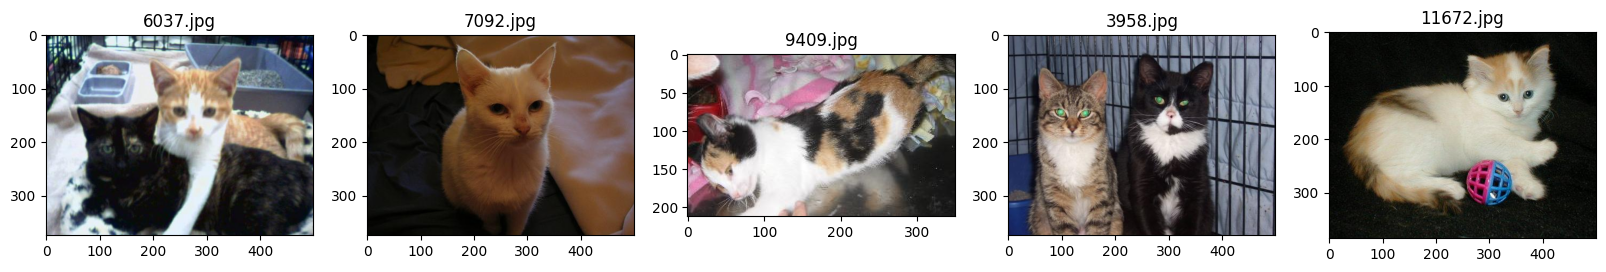

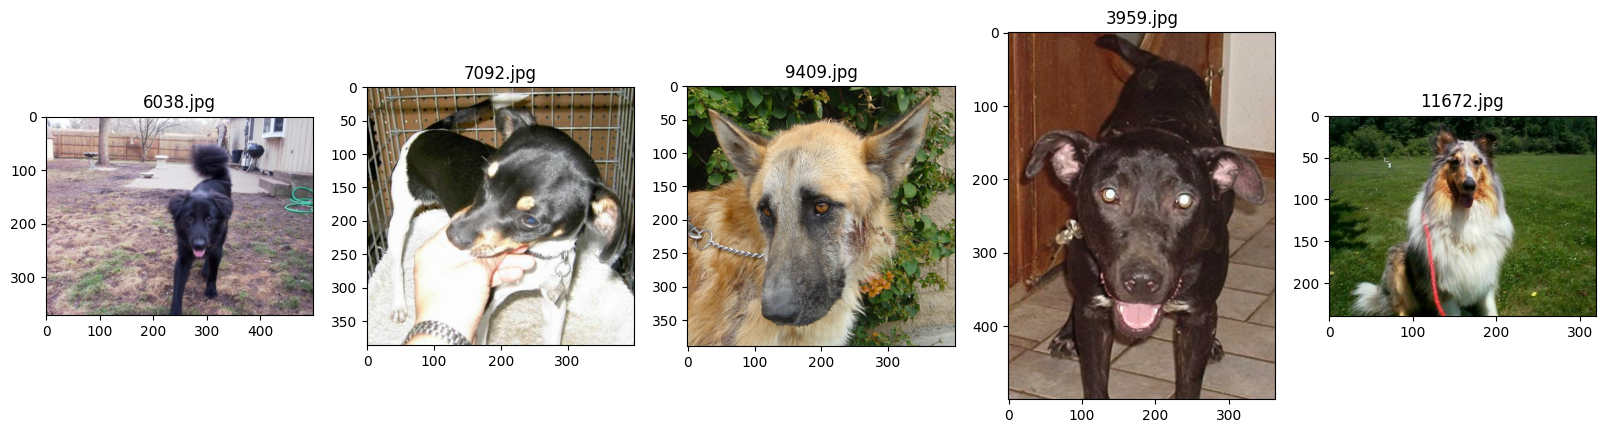

In [122]:
import os
import cv2
import random
import numpy as np
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt

#Visualizing random cats
plt.figure(figsize=(20,20))
img_folder=r"C:\Users\wtrindad\source\repos\NN_from_scratch\PetImages\Cat"
random.seed(93)
for i in range(5):
    file=random.choice(os.listdir(img_folder))
    image_path=os.path.join(img_folder,file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

#Visualizing random dogs
plt.figure(figsize=(20,20))
img_folder=r"C:\Users\wtrindad\source\repos\NN_from_scratch\PetImages\Dog"
random.seed(93)
for i in range(5):
    file=random.choice(os.listdir(img_folder))
    image_path=os.path.join(img_folder,file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)
    

We can create a dataset by parsing the names of the folders as the label, and loading the images as numpy arrays. By doing so we can also resize them using the `cv2` library which will make it easier to use them as inputs later on (at the price of distorting some of the images). We also turn them into `float32` format and divide them by 255 to keep the numbers small, and that way speed some calculations. Even though I chose to use colored (RGB) images it is very easy to turn them into grayscale with `cv2`. Either way, there were some grayscale images in the set which were removed else they would make it arder to work with the set.

In [123]:
%%writefile create_dataset.py
import os
import cv2
import numpy as np
def create_dataset(img_folder,IMG_WIDTH=32,IMG_HEIGHT=32):
    """
    Takes the path to the folder containing all images.
    Returns a list of images and a list of classes.
    """
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder,dir1)):
            image_path= os.path.join(img_folder,dir1,file)
            image= cv2.imread(image_path,cv2.COLOR_BGR2RGB)#For grayscale use cv2.IMREAD_GRAYSCALE
            if image is None:
                continue
            if len(image.shape) ==2: #This effectively removes the grayscale images since they do not have a third dimension
                continue
            image=cv2.resize(image,(IMG_HEIGHT, IMG_WIDTH),interpolation=cv2.INTER_AREA)
            image=np.array(image)
            image=image.astype('float32')
            image/=255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name


Overwriting create_dataset.py


In [124]:
from create_dataset import create_dataset
IMG_WIDTH=32
IMG_HEIGHT=32
img_folder=r"C:\\Users\\wtrindad\\source\\repos\\NN_from_scratch\\PetImages"
img_data,class_name=create_dataset(img_folder,IMG_WIDTH,IMG_HEIGHT)

In [125]:
len(img_data)
img_data = np.asarray(img_data)
img_data.shape

(24941, 32, 32, 3)

In [126]:
target_dict={'Cat':1,'Dog':0} #Let's encode our labels
class_name=[target_dict[class_name[i]] for i in range(len(class_name))]

The data set has  24941  images.
[[[0.1764706  0.16862746 0.15686275]
  [0.1764706  0.1764706  0.15294118]
  [0.19607843 0.2        0.16470589]
  ...
  [0.4117647  0.3137255  0.28627452]
  [0.45490196 0.35686275 0.3254902 ]
  [0.5686275  0.6313726  0.63529414]]

 [[0.16862746 0.16078432 0.14117648]
  [0.18431373 0.1882353  0.16470589]
  [0.20784314 0.21176471 0.1764706 ]
  ...
  [0.39607844 0.30980393 0.2784314 ]
  [0.43137255 0.34901962 0.31764707]
  [0.5686275  0.6313726  0.654902  ]]

 [[0.15294118 0.15686275 0.12156863]
  [0.1764706  0.18431373 0.14901961]
  [0.18039216 0.18039216 0.14901961]
  ...
  [0.3882353  0.3019608  0.28235295]
  [0.3764706  0.3137255  0.2901961 ]
  [0.54509807 0.60784316 0.6313726 ]]

 ...

 [[0.07450981 0.07450981 0.07450981]
  [0.06666667 0.07058824 0.07058824]
  [0.06666667 0.06666667 0.06666667]
  ...
  [0.21176471 0.23921569 0.29411766]
  [0.17254902 0.19215687 0.24705882]
  [0.16470589 0.18431373 0.23921569]]

 [[0.09019608 0.09019608 0.09019608]
  [0

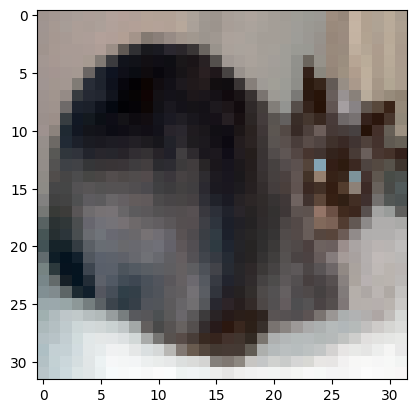

In [127]:
print("The data set has ", str(len(img_data)), " images.")
print(img_data[1]) #How the images look like as numpy arrays.
print("This image's label is ", str(class_name[10]))
plt.imshow(img_data[10])

##### Splitting the data

As the set is not particularly big I will proceed with a simple train/test split where 85% of the data will go to the train fold, and the rest to the test fold. The data is currently organized and shows all approximately 12.5 thousand cat pictures first and then the dog ones. Luckily, `sklearn` has a `train_test_split()` function that saves me the trouble of having to shuffle and splitting the data myself.

In [128]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(img_data,class_name,test_size=.15)

Length of the train set is 21199 images.
1


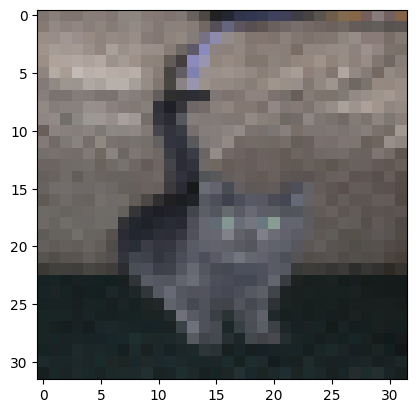

In [129]:
print("Length of the train set is", str(len(x_train)), "images.")
plt.imshow(x_train[3893])
print(y_train[3893])

Length of test set is 3742 images.
0


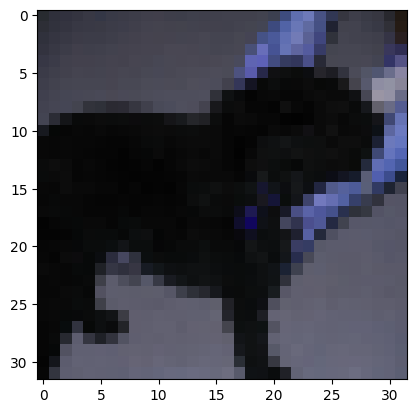

In [130]:
print("Length of test set is", str(len(y_test)), "images.")
plt.imshow(x_test[10])
print(y_test[10])

As a final step in the preprocessing of the data we flatten it, i.e., we turn it into a vector.

In [131]:
x_train_flat = x_train.reshape(x_train.shape[0], -1).T
print(x_train_flat.shape)

x_test_flat = x_test.reshape(x_test.shape[0], -1).T
print(x_test_flat.shape)

y_train = np.asarray(y_train).reshape(1,-1)
print(y_train.shape)

y_test = np.asarray(y_test).reshape(1,-1)
print(y_test.shape)


(3072, 21199)
(3072, 3742)
(1, 21199)
(1, 3742)


##### Defining the architecture

All the pieces of this project are ready for assembly. Before we put them together we must also define the architecture of the network. It should have an initial input layer, followed by L layers with N nodes in it.

In [132]:
layer_dims = [x_train_flat.shape[0],7,5,1]

Here we have a 3-layer model, with an input size of 3072 (32x32x3). The first layer has 7 hidden nodes, the second 5, and so on and so forth. As this is a simple classification problem with only two classes the ouput layer has only one node.

In [133]:
%%writefile dense_nn.py
import numpy as np
from update import update
from deep_model import deep_model
from init_param import init_param
from back_prop import deep_model_back
from cost_computation import cost_computation

def dense_nn(X,Y,layers_dims,learning_rate=0.0075,num_iterations=5000,print_cost=False):
    """
    Takes X (the data), Y (the labels), a list with the architecture, a given learning rate, number of iterations, and you get to choose whether to print the cost every 100 steps or not.
    Returns the parameters of the model which can then be used to make predictions.
    """
    costs=[]
    parameters=init_param(layers_dims)
    for i in range(0,num_iterations):
        AV,caches=deep_model(X,parameters)
        cost=cost_computation(AV,Y)
        grads=deep_model_back(AV,Y,caches)
        parameters=update(parameters,grads,learning_rate)
        if print_cost and i%100==0 or i==num_iterations-1:
            print("Cost after iteration {}: {}".format(i,np.squeeze(cost)))
        if i%100==0 or i==num_iterations:
            costs.append(cost)
    return parameters,costs

Overwriting dense_nn.py


In [135]:
from dense_nn import dense_nn
parameters,costs=dense_nn(x_train_flat,y_train,layer_dims,learning_rate=0.3,num_iterations=1,print_cost=True)

Cost after iteration 0: 0.6931473570002695


##### Training the model

We know now that all parts of this neural network seem to be working as they should. We proceed to train it with more iterations.

In [25]:
parameters,costs=dense_nn(x_train_flat,y_train,layer_dims,learning_rate=0.3,num_iterations=150,print_cost=True) #if you are on a hurry reduce the num_interations to about 150

Cost after iteration 0: 0.6931476211931962
Cost after iteration 100: 0.6931428256837574
Cost after iteration 200: 0.6931427585555607
Cost after iteration 300: 0.6931427113871137
Cost after iteration 400: 0.6931426599990893
Cost after iteration 500: 0.6931426027453644
Cost after iteration 600: 0.6931425295832803
Cost after iteration 700: 0.6931424264704766
Cost after iteration 800: 0.6931422717372845
Cost after iteration 900: 0.6931420510290067
Cost after iteration 1000: 0.6931417101696915
Cost after iteration 1100: 0.6931411704042562
Cost after iteration 1200: 0.6931403022725068
Cost after iteration 1300: 0.6931388009666635
Cost after iteration 1400: 0.6931358613668297
Cost after iteration 1499: 0.693129163436304


##### Predicting

Finally we can make predictios for both the train and test sets.

In [22]:
%%writefile predict.py
import numpy as np
from deep_model import deep_model
def predict(X,y,parameters):
    """
    Takes X (the data), y (the labels), and parameters (from the dense_nn() function).
    Returns predictions p for the chosen data set X.
    """
    m=X.shape[1]
    n=len(parameters)//2
    p=np.zeros((1,m))
    probs,caches=deep_model(X, parameters)
    for i in range(0,probs.shape[1]):
        if probs[0,i]>0.5:
            p[0,i]=1
        else:
            p[0,i]=0
    print("Accuracy: "  + str(np.sum((p == y)/m)))   
    return p

Overwriting predict.py


In [23]:
from predict import predict
predict_train=predict(x_train_flat,y_train,parameters)

Accuracy: 0.5014859191471296


In [24]:
predict_test=predict(x_test_flat,y_test,parameters)

Accuracy: 0.4909139497594869
